# TP de Video Processing

## Importation des modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import calendar
import time
import cv2
import numpy as np

## **Question A**
Partant de deux frames F1 et F2 où F2 succède à F1 dans le temps, estimez par une méthode pixel-wise les vecteurs de mouvements des pixels de la frame F1 vers F2 (en admettant l’hypothèse de l’intensité constante).

## Chargement des frames

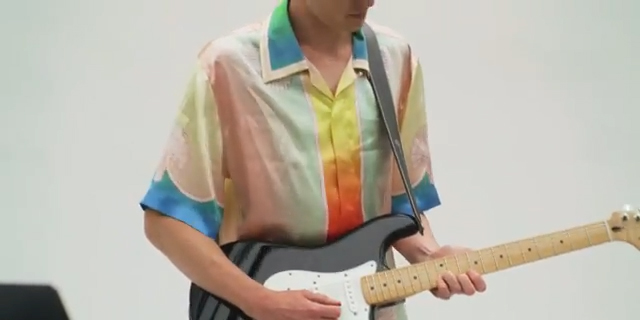

In [51]:
self.frame_array_1 = Image.open("images/LF016.jpg")
img2 = Image.open("images/LF017.jpg")
self.frame_array_1

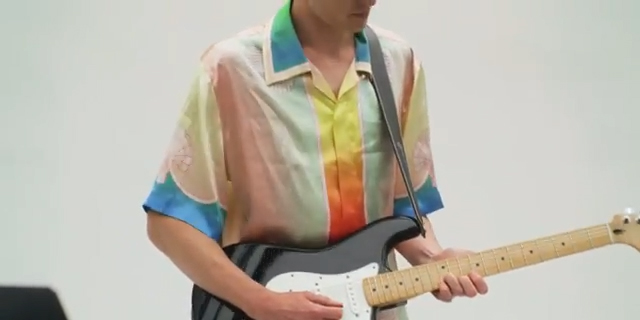

In [3]:
img2

## Création des nd arrays associés aux images

In [118]:
frame_array_1 = np.asarray(frame_array_1)
frame_array_2 = np.asarray(img2)
# Vérification 
assert frame_array_1.shape == frame_array_2.shape

## Fonction qui mesure l'écart entre 2 pixels

Il s'agit ici d'appliquuer la distance de Manhattan (ou $\lVert.\lVert_1$) entre deux vecteurs qui sont dans ce cas des pixels en RGB.

In [5]:
def get_absolute_diff_sum(pixel_a, pixel_b):
    return (abs((pixel_a).astype(int) - (pixel_b).astype(int))).sum()

## Déterminer les vecteurs de mouvement

### Déterminer le vecteur au niveau d'un pixel

La fonction ci-dessous va prendre un pixel aux coordonnées `x,y` de la `frame_1` et va chercher dans un voisinage de taille `max_distance` (autour de `(x,y)` )  un pixel de la `frame_2` un pixel ayant une luminescence (une valeur RGB) la plus proche.

In [6]:
def get_closer_pixel(frame_array_1,frame_array_2,x,y, max_distance):
    
    best_pixel_coord = None
    best_pixel = None
    pixel_to_find = frame_array_1[x][y]
    # On cherche d'abord les pixels les plus éloignées en partant d'une distance de `max_distance`
    for current_distance in range(max_distance,-1,-1):
        # On fixe les limites d'abscisse et d'ordonnée du tableau
        x_left_bound = max(0,x-current_distance)
        x_right_bound = min(frame_array_1.shape[0],x+current_distance+1)
        y_bottom_bound,y_top_bound =max(0,y-current_distance),min(frame_array_1.shape[1],y+current_distance+1)
        for x_neigbour in range(x_left_bound,x_right_bound):
            for y_neigbour in range(y_bottom_bound,y_top_bound):
                
                if((abs(x_neigbour-x) + abs(y_neigbour-y)) == current_distance):
                    neigbour_pixel = frame_array_2[x_neigbour][y_neigbour]
                    pixel_diff_sum = get_absolute_diff_sum(neigbour_pixel, pixel_to_find)
                    need_to_change = (best_pixel_coord is None)
                    # On vérifie s'il y a une meilleure proximité en comparaison du pixel précédent
                    need_to_change = need_to_change or (pixel_diff_sum <= get_absolute_diff_sum(best_pixel, pixel_to_find))
                    if(need_to_change):
                        # On met à jour les coordonnées dans le cas ou un pixel de la frame_2 est meilleur candidat que le précédent.
                        best_pixel_coord = x_neigbour,y_neigbour
                        best_pixel = neigbour_pixel
        
    return best_pixel_coord
    

Après avoir déterminer le pixel de la frame 2 le plus proche de celui de la frame 1 on renvoie un tuple qui correspond à un vecteur de mouvement.

In [7]:
def get_move_vector(frame_array_1,frame_array_2,x,y,step):
    new_x, new_y = get_closer_pixel(frame_array_1,frame_array_2,x,y,step)
    return new_x-x, new_y-y

### Déterminer les vecteurs de mouvement au niveau de tous les pixels de la frame

Le but va être de générer deux ndarrays u et v. Ces deux arrays correspondent respectivement aux coordonées directionnelles de chaque point de la frame.
u va représenter les abcisses de chaque point et v les ordonnées. 

In [9]:
def generate_move_vectors(frame_array_1,frame_array_2,step):
    count =0
    u = np.ndarray(shape=frame_array_1.shape[0:2])
    u.fill(0.)
    v = np.ndarray(shape=frame_array_1.shape[0:2])
    v.fill(0.)
    total_count = frame_array_1.shape[0]*frame_array_1.shape[1]
    first = time.time()
    for x in range(frame_array_1.shape[0]):
        for y in range(frame_array_1.shape[1]):
            if(count == total_count//100):
                second = time.time()
                estimated_time = (second -first)*100
                print(f'{int(estimated_time)//60} minutes and {int(estimated_time)%60} seconds left ')
            vector= get_move_vector(frame_array_1,frame_array_2,x,y,step)
            u[x][y]= vector[0]
            v[x][y]= vector[1]
            count+=1
    return u,v


## Afficher les vecteurs de mouvement

Ensuite nous générons les meshgrids ainsi que les vecteurs de mouvement u et v.

In [10]:
STEP = 5
window_size = 5
def compute_movement_vectors(frame_array_1,frame_array_2):
    u,v = generate_move_vectors(frame_array_1,frame_array_2,STEP)
    u =  u[::window_size,::window_size]
    v = v[::window_size,::window_size]
    x =  np.arange(frame_array_1.shape[1])  
    y = np.arange(frame_array_1.shape[0]-1,-1,-1) 
    X, Y = np.meshgrid(x[::window_size], y[::window_size])
    return X,Y, u, v

X,Y, u, v = compute_movement_vectors(frame_array_1,frame_array_2)

2 minutes and 16 seconds left 


Il faut maintenant afficher via Quiver l'ensemble des vecteurs de mouvements

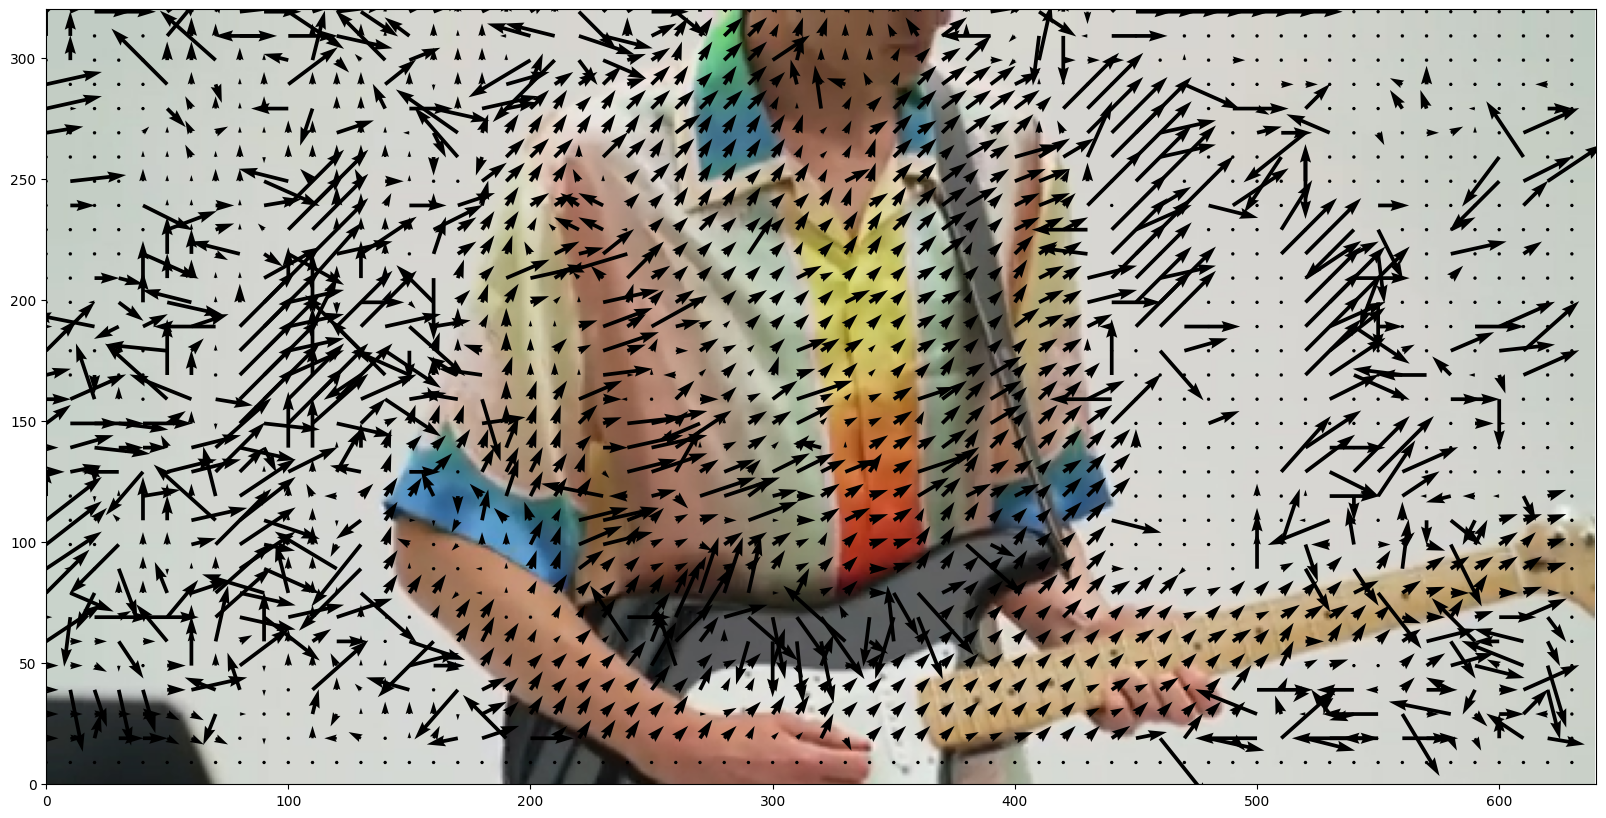

In [83]:
def display_movement_vectors( X,Y, u, v):
    fig, ax = plt.subplots(figsize =(20, 20))
    ax.quiver(X, Y, u, v,scale=250)
    ax.axis([0, frame_array_1.shape[1], 0,frame_array_1.shape[0] ])
    ax.set_aspect('equal')
    plt.imshow(np.flip(frame_array_1,(0)))
    plt.show()

display_movement_vectors(X,Y, u, v)

# (B) Méthode par bloc

In [138]:
class BlockWiseComputer:
    block_size = 10
    window_size = 10
    def set_block_size(self,block_size :int) -> None:
        self.block_size = block_size
    def set_window_size(self,window_size :int) -> None:
        self.window_size = window_size

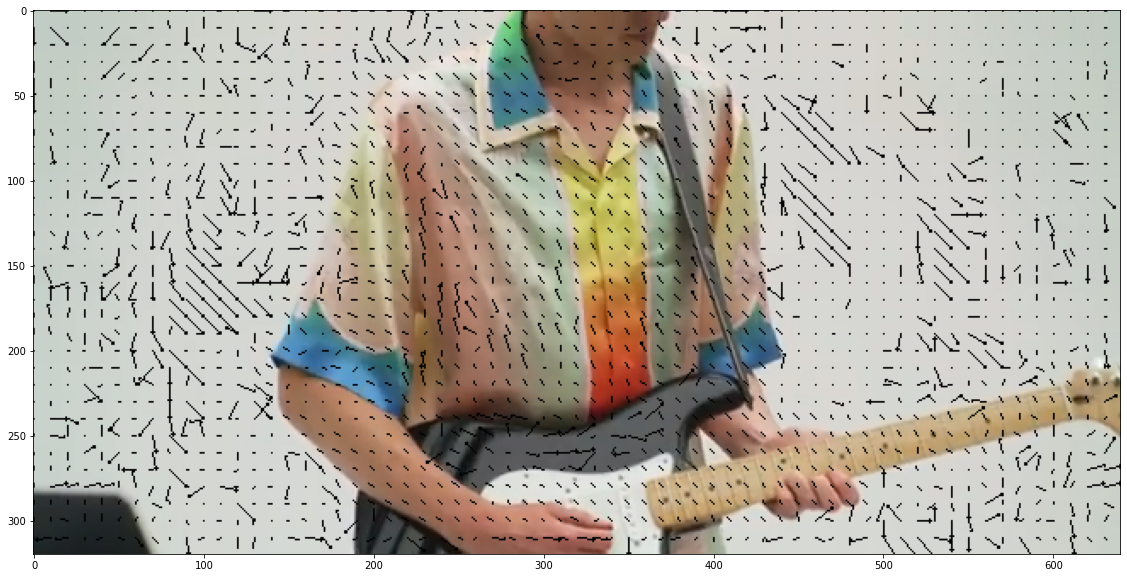

In [140]:

class FromScratchBlockWiseComputer(BlockWiseComputer):
    def __init__(self, frame_1_file_name :str, frame_2_file_name :str ) -> None:
        img1 = Image.open(frame_1_file_name)
        img2 = Image.open(frame_2_file_name)
        self.frame_array_1 = np.asarray(img1)
        self.frame_array_2 = np.asarray(img2)
    
    def from_scratch_block_wise(self) -> None :
        height, width = self.frame_array_1.shape[:2]
        flow_vectors = []
        for x in range(0,height,self.block_size):
            for y in range(0,width,self.block_size):
                left_x_bound = max(x-self.window_size,0)
                right_x_bound = min(x+self.window_size,height-self.block_size)
                left_y_bound = max(y-self.window_size,0)
                right_y_bound = min(y+self.window_size,width-self.block_size)
                block_1 = self.frame_array_1[x:x+self.block_size,y:y+self.block_size].astype(int)
                min_cost = float('inf')
                best_match = (0,0)
                for i in range(left_x_bound,right_x_bound):
                    for j in range(left_y_bound,right_y_bound):
                        block_2 = self.frame_array_2[i:i+self.block_size,j:j+self.block_size].astype(int)
                        cost = np.mean(np.abs(block_1 - block_2))
                        if(cost < min_cost):
                            min_cost =cost
                            best_match = (x,y,x-i,y-j)
                flow_vectors.append(best_match)
        for point in flow_vectors:
            x,y,dx,dy = point
            cv2.arrowedLine(self.frame_array_1, (y,x), (int(dy+y),int(dx+x)), (0, 0, 0),1)
        fig, ax = plt.subplots(figsize =(20, 10))
        plt.imshow(self.frame_array_1)
    def __call__(self) -> None:
        self.from_scratch_block_wise()
        
        

blockwisecomputer = FromScratchBlockWiseComputer("images/LF016.jpg","images/LF017.jpg")

blockwisecomputer()

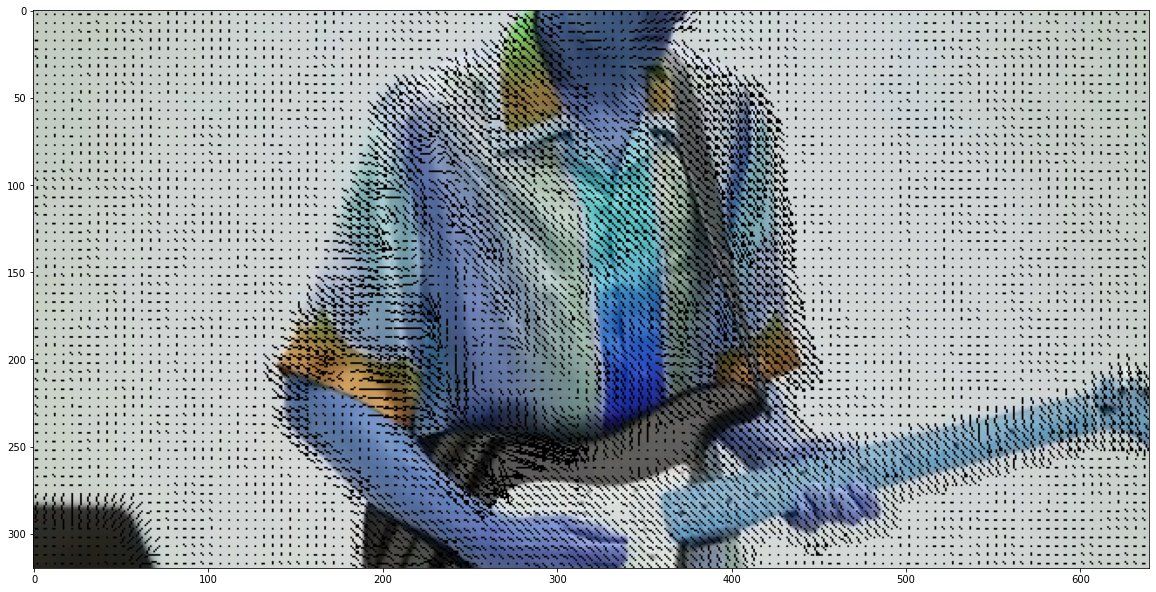

In [142]:

class CV2BlockWiseComputer(BlockWiseComputer):
    def __init__(self, frame_1_file_name :str, frame_2_file_name :str ) -> None:
        self.frame_array_1 = cv2.imread(frame_1_file_name)
        self.frame_array_2 = cv2.imread(frame_2_file_name)
        return
    
    def __call__(self) -> None:
        
        # convertir les images en niveau de gris
        gray1 = cv2.cvtColor(self.frame_array_1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(self.frame_array_2, cv2.COLOR_BGR2GRAY)
        shift_size = 5

        # calculer le flux optique avec la méthode block-wise
        flow = cv2.calcOpticalFlowFarneback(gray1, gray2, flow=None, pyr_scale =0.5, levels=5, winsize=self.window_size, iterations=5, poly_n=16, poly_sigma=1.2, flags=0)

        ## créer une grille de points pour dessiner les vecteurs de flux
        h, w = gray1.shape
        grid_y, grid_x = np.mgrid[shift_size//2:h:shift_size, shift_size//2:w:shift_size].reshape(2, -1).astype(int)
        points = np.vstack([grid_x, grid_y]).T
        #
        ## dessiner les vecteurs de flux sur l'image 1
        fig, ax = plt.subplots(figsize =(20, 20))
        for x, y in points:
            dx, dy = flow[y, x]
            dx*=2
            dy*=2
            cv2.arrowedLine(self.frame_array_1, (x, y), (int(x+dx), int(y+dy)), (0, 0, 0))
        #
        ## afficher les images avec les vecteurs de flux dessinés

        plt.imshow(self.frame_array_1)
    
cv2_blockwisecomputer = CV2BlockWiseComputer("images/LF016.jpg","images/LF017.jpg")
cv2_blockwisecomputer()